# Tutorial Unlocking the Secrets of Trending Videos: A Comprehensive Analysis Approach to YouTube Data

-------------------------------------------------------------
Notebook created by Marcelo Amaral.
Assisted by GPT, a language model developed by OpenAI. Aug 2023
-------------------------------------------------------------

In the dynamic world of YouTube, trending videos are like gold. They capture attention, drive engagement, and create cultural moments. But what makes a video trend? While the algorithm remains proprietary, we can analyze certain characteristics to decode patterns and preferences.

## Import necessary libraries

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from nltk.stem import WordNetLemmatizer
import string

## Loading and Segmenting YouTube Comments

In [5]:
# Read the YT data
xlsx_videos_name = 'data/YT_data_sample_video_enriched.xlsx'
videos_df = pd.read_excel(xlsx_videos_name)
print(videos_df.columns)

Index(['videoId', 'title', 'description', 'publishedAt', 'channelId',
       'categoryId', 'category', 'viewCount', 'likeCount', 'commentCount',
       'tags', 'channelTitle', 'thumbnails', 'isTrending', 'duration',
       'dimension', 'definition', 'caption', 'licensedContent', 'projection',
       'uploadStatus', 'privacyStatus', 'license', 'embeddable',
       'publicStatsViewable', 'madeForKids', 'favoriteCount',
       'topicCategories', 'viewCount_mean', 'viewCount_std', 'likeCount_mean',
       'likeCount_std', 'commentCount_mean', 'commentCount_std',
       'viewCount_to_avg_viewCount_ratio', 'likeCount_to_avg_likeCount_ratio',
       'commentCount_to_avg_commentCount_ratio'],
      dtype='object')


In [6]:
# Read the YT data
xlsx_channels_name = 'data/YT_data_sample_channel_larger.xlsx'
channels_df = pd.read_excel(xlsx_channels_name)
print(channels_df.columns)


Index(['channelId', 'channelTitle', 'description', 'publishedAt', 'videoCount',
       'viewCount', 'subscriberCount', 'country', 'customUrl',
       'topicCategories', 'madeForKids', 'keywords', 'hasVideoTrending',
       'numberVideoTrending', 'viewCount_mean', 'viewCount_std',
       'likeCount_mean', 'likeCount_std', 'commentCount_mean',
       'commentCount_std'],
      dtype='object')


In [7]:
# Compute the correlation
correlation = channels_df['subscriberCount'].corr(channels_df['viewCount'])

print(f"Correlation between subscriberCount and viewCount: {correlation:.4f}")


Correlation between subscriberCount and viewCount: 0.7374


In [12]:

# Select features for clustering
features = ['viewCount', 'likeCount', 'commentCount']
X = videos_df[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform k-means clustering
kmeans = KMeans(n_clusters=5) # You can choose a different number of clusters
videos_df['cluster'] = kmeans.fit_predict(X_scaled)


/home/mamaral/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Merge video and channel data on channelId
merged_data = pd.merge(videos_df, channels_df, on='channelId')

# Perform correlation analysis (example using Pearson correlation)
correlation = merged_data[['cluster', 'viewCount_y']].corr(method='pearson')


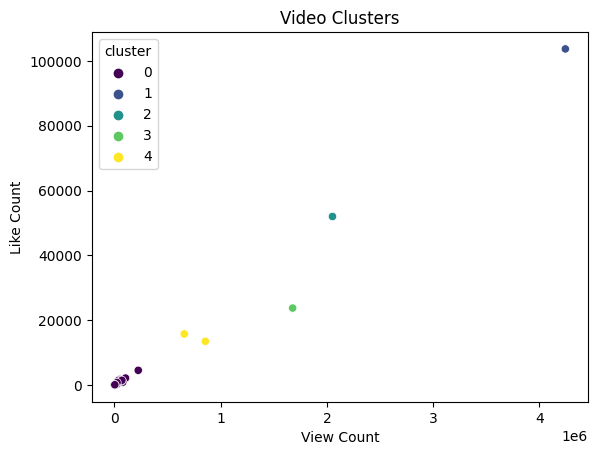

In [16]:
# Plot clusters using seaborn
sns.scatterplot(data=videos_df, x='viewCount', y='likeCount', hue='cluster', palette='viridis')
plt.title('Video Clusters')
plt.xlabel('View Count')
plt.ylabel('Like Count')
plt.show()


In [17]:
cluster_summary = videos_df.groupby('cluster')[features].mean()
print(cluster_summary)


            viewCount      likeCount  commentCount
cluster                                           
0        9.876243e+03     208.542373     34.412429
1        4.244127e+06  103711.000000  15935.000000
2        2.052430e+06   51987.000000   6288.000000
3        1.677570e+06   23723.000000   3928.000000
4        7.566380e+05   14599.500000   2716.000000


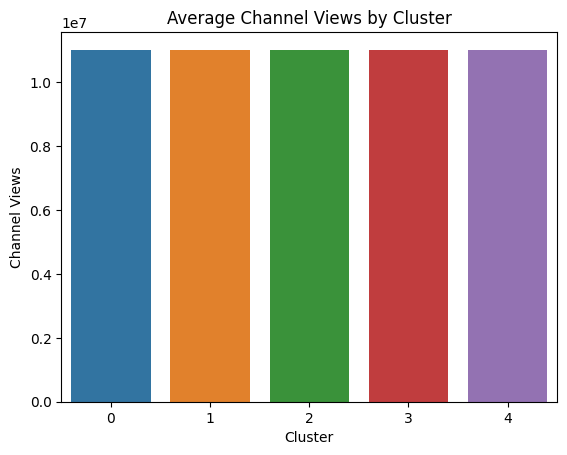

In [18]:
sns.barplot(x='cluster', y='viewCount_y', data=merged_data, estimator=np.mean)
plt.title('Average Channel Views by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Channel Views')
plt.show()


In [19]:
centroids = kmeans.cluster_centers_
original_centroids = scaler.inverse_transform(centroids)
original_centroids_df = pd.DataFrame(original_centroids, columns=features)
print(original_centroids_df)


      viewCount      likeCount  commentCount
0  9.876243e+03     208.542373     34.412429
1  4.244127e+06  103711.000000  15935.000000
2  2.052430e+06   51987.000000   6288.000000
3  1.677570e+06   23723.000000   3928.000000
4  7.566380e+05   14599.500000   2716.000000


In [22]:
# Calculate the distance from each video to each centroid
distances_to_centroids = distance.cdist(X_scaled, kmeans.cluster_centers_, 'euclidean')

# Get the indices of the 5 closest videos to each centroid
closest_videos_idx = np.argsort(distances_to_centroids, axis=0)[:20]

# Print representative videos
for cluster in range(kmeans.n_clusters):
    print(f"Cluster {cluster} Representatives:")
    for idx in closest_videos_idx[:, cluster]:
        representative_video = videos_df.loc[idx]
        print(representative_video[['title', 'viewCount', 'likeCount', 'commentCount']])
    print("\n")


Cluster 0 Representatives:
title           Garrett Lisi's Elementary Particle Explorer
viewCount                                              8722
likeCount                                               263
commentCount                                             30
Name: 114, dtype: object
title           Trailer for Klee Irwin's "Are We In A Simulati...
viewCount                                                   10679
likeCount                                                     230
commentCount                                                   25
Name: 3, dtype: object
title           Fang Fang - The Quasicrystalline Spin Network
viewCount                                               10900
likeCount                                                 165
commentCount                                               25
Name: 145, dtype: object
title           Dr. Moninder Singh Modgil - The Geometry of Time
viewCount                                                   9441
likeCount         

In [23]:
merged_data = pd.merge(videos_df, channels_df, on='channelId')

In [24]:
cluster_counts = merged_data[merged_data['cluster'].isin([2, 3])].groupby('channelId')['videoId'].count().reset_index(name='cluster_2_3_count')


In [25]:
final_data = pd.merge(channels_df, cluster_counts, on='channelId', how='left')
final_data['cluster_2_3_count'] = final_data['cluster_2_3_count'].fillna(0) # Fill missing values with 0


In [26]:
correlation_cluster_2_3 = final_data[['cluster_2_3_count', 'viewCount']].corr(method='pearson')
print(correlation_cluster_2_3)


                   cluster_2_3_count  viewCount
cluster_2_3_count           1.000000  -0.018158
viewCount                  -0.018158   1.000000


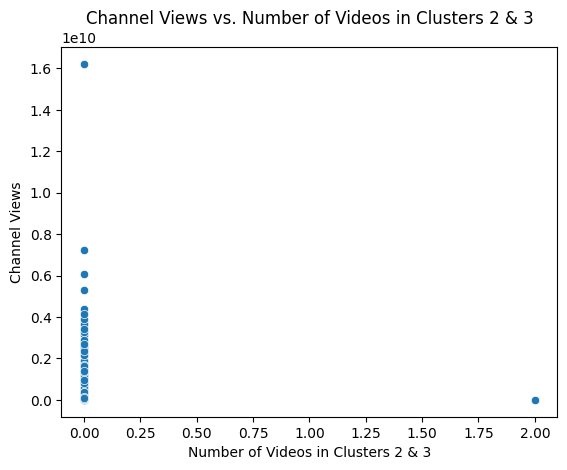

In [27]:
sns.scatterplot(data=final_data, x='cluster_2_3_count', y='viewCount')
plt.title('Channel Views vs. Number of Videos in Clusters 2 & 3')
plt.xlabel('Number of Videos in Clusters 2 & 3')
plt.ylabel('Channel Views')
plt.show()


# Apendix - more analysis

Analyzing the common characteristics of trending videos can provide insights into what makes a video likely to trend, which can be beneficial for content creators aiming to increase their video's reach and engagement. Here's a structured approach to identify these characteristics:

    Descriptive Analysis:
        Duration: Analyze the average duration of trending videos compared to non-trending ones. Is there an optimal video length?
        Category: Which categories are most represented among trending videos?
        Engagement: Compare likes, comments, and their ratios to views for trending versus non-trending videos. High engagement may correlate with trending status.
        Publishing Time: Is there a specific time or day of the week when trending videos are usually published?

    Content Analysis:
        Tags and Keywords: Examine the tags associated with trending videos. Are there common tags or topics?
        Description: Analyze the descriptions of trending videos for common keywords or patterns.
        Title: Are there certain buzzwords or phrasings commonly found in the titles of trending videos?

    Channel Characteristics:
        Channel Age: Do trending videos come from older, more established channels or newer ones?
        Subscriber Count: Analyze the average subscriber count of channels with trending videos. Do bigger channels have an advantage, or can smaller channels also get into trending?
        Channel Category: What are the common categories of channels that produce trending videos?

    Technical Aspects:
        Video Quality: Look into attributes like definition and dimension to see if trending videos tend to be of higher quality (e.g., HD).
        Caption: Do trending videos often have captions (indicating accessibility for a broader audience)?
        Embeddable: Are trending videos more likely to be embeddable on other platforms, leading to more views?

    External Factors:
        Collaborations: Do collaborations between channels or featuring popular personalities lead to videos trending?
        Current Events: Are the trending videos often related to current events, holidays, or trending topics globally?

    Advanced Analysis (If Data Available):
        Sentiment Analysis: Analyze the comments of trending videos to see if there's a prevalent sentiment (positive, negative, neutral).
        Viewer Demographics: If you have access to viewer demographic data, you can see if trending videos appeal to a specific age group, country, or gender.

#### Correlations

Correlation between number of trending videos and subscriber count: 0.62
Correlation between number of trending videos and view count: 0.38


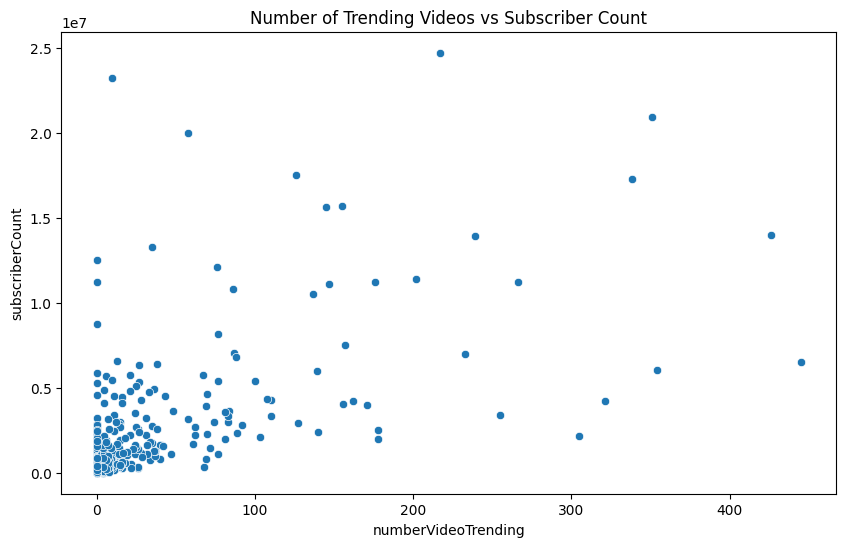

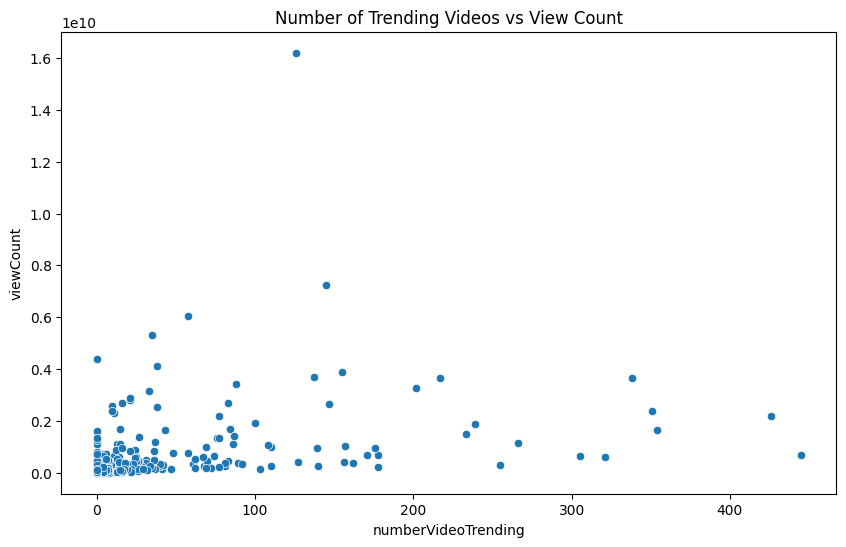

In [28]:
# Calculate the correlation
correlation_with_subscribers = channels_df['numberVideoTrending'].corr(channels_df['subscriberCount'])
correlation_with_views = channels_df['numberVideoTrending'].corr(channels_df['viewCount'])

print(f"Correlation between number of trending videos and subscriber count: {correlation_with_subscribers:.2f}")
print(f"Correlation between number of trending videos and view count: {correlation_with_views:.2f}")

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Scatter plot of Number of Trending Videos vs Subscriber Count
sns.scatterplot(x='numberVideoTrending', y='subscriberCount', data=channels_df)
plt.title('Number of Trending Videos vs Subscriber Count')
plt.show()

# Scatter plot of Number of Trending Videos vs View Count
plt.figure(figsize=(10, 6))
sns.scatterplot(x='numberVideoTrending', y='viewCount', data=channels_df)
plt.title('Number of Trending Videos vs View Count')
plt.show()


### trending videos descriptive analysis

In [29]:
def iso8601_duration_to_seconds(duration):
    """
    Convert ISO 8601 duration format to total seconds.
    """
    # Extract hours, minutes, and seconds
    hours = re.search('(\d+)H', duration)
    minutes = re.search('(\d+)M', duration)
    seconds = re.search('(\d+)S', duration)
    
    hours = int(hours.group(1)) if hours else 0
    minutes = int(minutes.group(1)) if minutes else 0
    seconds = int(seconds.group(1)) if seconds else 0

    return hours * 3600 + minutes * 60 + seconds



In [32]:
# Load the data

# Calculate average duration for trending and non-trending videos
# Apply the function to the 'duration' column
videos_df['duration_seconds'] = videos_df['duration'].apply(iso8601_duration_to_seconds)


In [33]:

avg_duration_trending = videos_df[videos_df['isTrending'] == True]['duration_seconds'].mean()
avg_duration_non_trending = videos_df[videos_df['isTrending'] == False]['duration_seconds'].mean()

print(f"Average duration of trending videos: {avg_duration_trending:.2f} seconds")
print(f"Average duration of non-trending videos: {avg_duration_non_trending:.2f} seconds")
print(f"Average duration of trending videos: {avg_duration_trending/60:.2f} min")
print(f"Average duration of non-trending videos: {avg_duration_non_trending/60:.2f} min")

Average duration of trending videos: nan seconds
Average duration of non-trending videos: 2463.77 seconds
Average duration of trending videos: nan min
Average duration of non-trending videos: 41.06 min


In [34]:
# Count the number of trending videos in each category
trending_categories = videos_df[videos_df['isTrending'] == True]['category'].value_counts()

print("Number of trending videos per category:")
print(trending_categories)


Number of trending videos per category:
Series([], Name: count, dtype: int64)


In [35]:
# Calculate average likes, comments, and their ratios to views
avg_likes_trending = videos_df[videos_df['isTrending'] == True]['likeCount'].mean()
avg_comments_trending = videos_df[videos_df['isTrending'] == True]['commentCount'].mean()
avg_likes_to_views_trending = avg_likes_trending / videos_df[videos_df['isTrending'] == True]['viewCount'].mean()
avg_comments_to_views_trending = avg_comments_trending / videos_df[videos_df['isTrending'] == True]['viewCount'].mean()

avg_likes_non_trending = videos_df[videos_df['isTrending'] == False]['likeCount'].mean()
avg_comments_non_trending = videos_df[videos_df['isTrending'] == False]['commentCount'].mean()
avg_likes_to_views_non_trending = avg_likes_non_trending / videos_df[videos_df['isTrending'] == False]['viewCount'].mean()
avg_comments_to_views_non_trending = avg_comments_non_trending / videos_df[videos_df['isTrending'] == False]['viewCount'].mean()

print(f"Average likes for trending videos: {avg_likes_trending:.2f}")
print(f"Average comments for trending videos: {avg_comments_trending:.2f}")
print(f"Likes-to-views ratio for trending videos: {avg_likes_to_views_trending:.2f}")
print(f"Comments-to-views ratio for trending videos: {avg_comments_to_views_trending:.2f}")

print(f"Average likes for non-trending videos: {avg_likes_non_trending:.2f}")
print(f"Average comments for non-trending videos: {avg_comments_non_trending:.2f}")
print(f"Likes-to-views ratio for non-trending videos: {avg_likes_to_views_non_trending:.2f}")
print(f"Comments-to-views ratio for non-trending videos: {avg_comments_to_views_non_trending:.2f}")


Average likes for trending videos: nan
Average comments for trending videos: nan
Likes-to-views ratio for trending videos: nan
Comments-to-views ratio for trending videos: nan
Average likes for non-trending videos: 1349.08
Average comments for non-trending videos: 207.00
Likes-to-views ratio for non-trending videos: 0.02
Comments-to-views ratio for non-trending videos: 0.00


In [36]:
# Convert 'publishedAt' column to datetime format
videos_df['publishedAt'] = pd.to_datetime(videos_df['publishedAt'])

# Extract day of the week from 'publishedAt'
videos_df['published_day'] = videos_df['publishedAt'].dt.day_name()


In [37]:

# Count the number of trending videos published on each day
trending_days = videos_df[videos_df['isTrending'] == True]['published_day'].value_counts()

print("Number of trending videos published per day of the week:")
print(trending_days)



Number of trending videos published per day of the week:
Series([], Name: count, dtype: int64)


#### Videos with views on top 10% descriptive analysis

    Identify Videos with Higher Views:
        For simplicity, let's define videos with higher views as those in the top 10% of view counts in your dataset.

    Descriptive Analysis for High-View Videos:
        Duration: Average duration of high-view videos.
        Category: Which categories are most represented among high-view videos?
        Engagement: Compare likes, comments, and their ratios for high-view videos.
        Publishing Time: Check if there's a specific time or day of the week when high-view videos are usually published.

In [38]:

# Identify the top 10% of videos by view count
threshold = videos_df['viewCount'].quantile(0.9)
high_view_videos = videos_df[videos_df['viewCount'] > threshold]

# Duration
avg_duration_high_view = high_view_videos['duration_seconds'].mean()
print(f"Average duration of high-view videos: {avg_duration_high_view:.2f} seconds")

# Engagement
avg_likes_high_view = high_view_videos['likeCount'].mean()
avg_comments_high_view = high_view_videos['commentCount'].mean()
avg_likes_to_views_high_view = avg_likes_high_view / high_view_videos['viewCount'].mean()
avg_comments_to_views_high_view = avg_comments_high_view / high_view_videos['viewCount'].mean()

print(f"\nAverage likes for high-view videos: {avg_likes_high_view:.2f}")
print(f"Average comments for high-view videos: {avg_comments_high_view:.2f}")
print(f"Likes-to-views ratio for high-view videos: {avg_likes_to_views_high_view:.2f}")
print(f"Comments-to-views ratio for high-view videos: {avg_comments_to_views_high_view:.2f}")

# Publishing Time
high_view_videos['published_day'] = high_view_videos['publishedAt'].dt.day_name()
high_view_days = high_view_videos['published_day'].value_counts()

print("\nNumber of high-view videos published per day of the week:")
print(high_view_days)


Average duration of high-view videos: 2994.42 seconds

Average likes for high-view videos: 11989.63
Average comments for high-view videos: 1840.89
Likes-to-views ratio for high-view videos: 0.02
Comments-to-views ratio for high-view videos: 0.00

Number of high-view videos published per day of the week:
published_day
Friday       4
Thursday     4
Monday       3
Wednesday    3
Tuesday      2
Sunday       2
Saturday     1
Name: count, dtype: int64


/tmp/ipykernel_753357/907907415.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_view_videos['published_day'] = high_view_videos['publishedAt'].dt.day_name()


### Content Analysis

    Tags Analysis:
        We'll find out the most common tags associated with high-view videos.
    Description Analysis:
        Extract common keywords from the video descriptions to identify prevalent topics.
    Duration Analysis:
        We've already analyzed the duration for high-view videos, but we can further examine the distribution of durations to find if there's an optimal range.

#### Tags Analysis

In [39]:
from collections import Counter

# Split tags and count occurrences
all_tags = [tag for sublist in high_view_videos['tags'].dropna().str.split(',').tolist() for tag in sublist]
tag_counts = Counter(all_tags)

# Get the top 10 most common tags
common_tags = tag_counts.most_common(30)

print("Top 30 tags for high-view videos:")
for tag, count in common_tags:
    print(f"{tag}: {count}")


Top 30 tags for high-view videos:
 'theory of everything': 16
 'emergence theory': 16
 'mathematics': 13
 'quantum gravity': 12
 'physics': 12
 'science': 12
 'math': 11
 'quantum gravity research': 10
 'physicist': 9
 'scientist': 9
 'mathematician': 9
 'quantum mechanics': 9
 'quantum physics': 9
 'irwin': 9
 'irwin klee': 9
 'klee irwin': 8
 'quantum': 8
 'E8 lattice': 8
 'maths': 7
 'golden ratio': 7
 'Klee Irwin': 7
['Consciousness': 6
 'artificial intelligence': 6
 'deep learning': 6
 'UFO': 6
 'aliens': 6
 'end of the world': 6
 'apocalypse': 6
 'simulation hypothesis': 6
 'self-simulation hypothesis': 6


#### Description Analysis

In [42]:
# If you haven't downloaded the stopwords dataset, you can do so using nltk.download('stopwords')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize descriptions and count occurrences, excluding stopwords
all_words = [word for sublist in high_view_videos['description'].dropna().str.lower().str.split().tolist() for word in sublist]
filtered_words = [word for word in all_words if word not in stop_words]
word_counts = Counter(filtered_words)

# Get the top 10 most common words
common_words = word_counts.most_common(30)

print("\nTop 30 keywords in descriptions for high-view videos:")
for word, count in common_words:
    print(f"{word}: {count}")



Top 30 keywords in descriptions for high-view videos:
qgr: 55
research: 38
reality: 35
made: 29
quantum: 27
website:: 27
klee: 25
philosophy: 21
scientific: 19
would: 18
gravity: 17
visit: 17
one: 16
physics: 16
read: 16
papers: 16
http://www.quantumgravityresearch.org: 14
know: 14
twitter:: 14
irwin's: 14
materialism,: 13
information: 13
belief: 13
universal: 13
could: 13
picture: 13
get: 13
qgr’s: 13
scientists:: 13
http://www.quantumgravityresearch.org/about-quantum: 13


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mamaral/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Duration Analysis

In [43]:
# Convert 'duration_seconds' to minutes
high_view_videos['duration_minutes'] = high_view_videos['duration_seconds'] / 60


/tmp/ipykernel_753357/19573583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_view_videos['duration_minutes'] = high_view_videos['duration_seconds'] / 60


Average duration of high-view videos: 49.91 minutes
Median duration of high-view videos: 29.68 minutes
Most common duration of high-view videos: 2.12 minutes


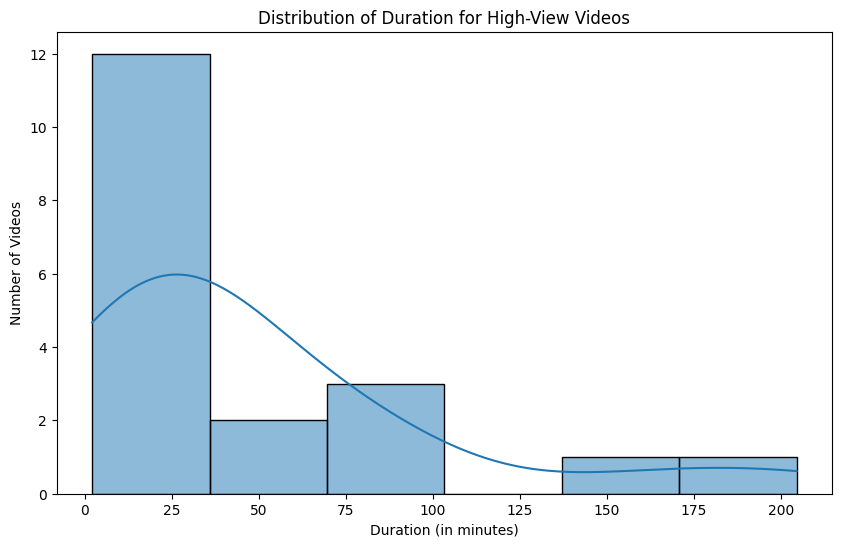

In [44]:

# Compute summary statistics
avg_duration = high_view_videos['duration_minutes'].mean()
median_duration = high_view_videos['duration_minutes'].median()
mode_duration = high_view_videos['duration_minutes'].mode()[0]  # Getting the first mode in case there are multiple

# Print the statistics
print(f"Average duration of high-view videos: {avg_duration:.2f} minutes")
print(f"Median duration of high-view videos: {median_duration:.2f} minutes")
print(f"Most common duration of high-view videos: {mode_duration:.2f} minutes")

# Plotting the distribution of durations in minutes
plt.figure(figsize=(10, 6))
sns.histplot(high_view_videos['duration_minutes'], kde=True)
plt.title('Distribution of Duration for High-View Videos')
plt.xlabel('Duration (in minutes)')
plt.ylabel('Number of Videos')
plt.show()


In [45]:
missing_durations = high_view_videos['duration_seconds'].isnull().sum()

print(f"Number of high-view videos without a specified duration: {missing_durations}")

short_videos_count = high_view_videos[high_view_videos['duration_seconds'] < 60].shape[0]

print(f"Number of high-view videos with a duration of less than 1 minute: {short_videos_count}")


Number of high-view videos without a specified duration: 0
Number of high-view videos with a duration of less than 1 minute: 0


In [46]:
# Filter videos with duration less than x minute
short_videos_df = high_view_videos[high_view_videos['duration_seconds'] < 600]

# Randomly sample 5 videos from the filtered dataset
sample_videos = short_videos_df.sample(n=1, random_state=42)[['title', 'videoId', 'channelTitle']]

# Print the details for the sampled videos
for index, row in sample_videos.iterrows():
    print(f"Title: {row['title']}")
    print(f"URL: https://www.youtube.com/watch?v={row['videoId']}")
    print(f"Channel: {row['channelTitle']}\n")


Title: Klee Irwin - Why Use an 8-Dimensional Shape to Describe 3-Dimensional Reality?
URL: https://www.youtube.com/watch?v=PKXJb4Ok9hQ
Channel: Quantum Gravity Research



The product of views and duration (referred to as "watch time" in this context) is a valuable metric for platforms like YouTube. In fact, YouTube's algorithm uses watch time as a primary metric for recommending videos.

One idea is to analyze the product of views and duration to determine the "sweet spot" for video length.

To determine the optimal video duration in terms of watch time:

    Compute Watch Time: Create a new column in your dataset called "watch_time" which is a product of views and duration.
    Analyze Watch Time vs. Duration: Plot "watch_time" against "duration" to visualize the relationship.
    Optimization Analysis: This is slightly more involved. It involves determining which duration maximizes the watch time. For this, you can group by video duration and sum the watch time. This will give you the total watch time for videos of each duration. Plotting this could give you an insight into the optimal video length.

In [47]:
# Compute watch time for each video as the product of views and duration in seconds
videos_df['watch_time'] = videos_df['viewCount'] * videos_df['duration_seconds']


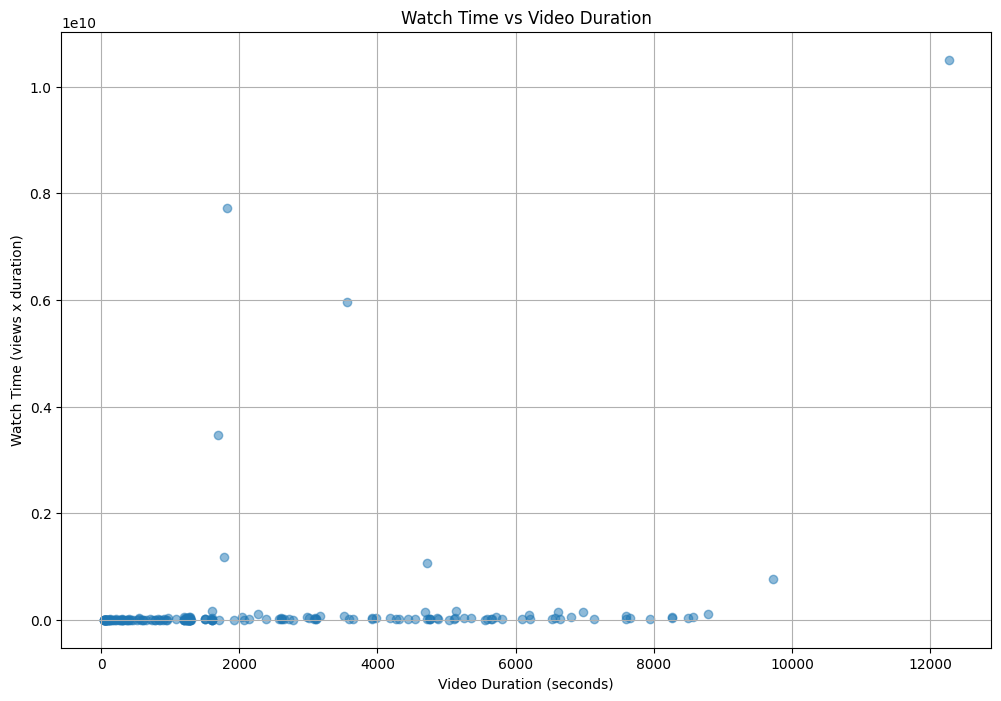

In [48]:
# Plotting the relationship between watch time and video duration
plt.figure(figsize=(12, 8))
plt.scatter(videos_df['duration_seconds'], videos_df['watch_time'], alpha=0.5)
plt.title('Watch Time vs Video Duration')
plt.xlabel('Video Duration (seconds)')
plt.ylabel('Watch Time (views x duration)')
plt.grid(True)
plt.show()


In [49]:
# Descriptive statistics for video duration
duration_stats = videos_df['duration_seconds'].describe(percentiles=[.25, .75, .95])

# Descriptive statistics for watch time
watch_time_stats = videos_df['watch_time'].describe(percentiles=[.25, .75, .95])

# Correlation between duration and watch time
correlation = videos_df['duration_seconds'].corr(videos_df['watch_time'])

duration_stats, watch_time_stats, correlation


(count      182.000000
 mean      2463.769231
 std       2508.123113
 min         34.000000
 25%        524.500000
 50%       1289.000000
 75%       4127.500000
 95%       7602.500000
 max      12275.000000
 Name: duration_seconds, dtype: float64,
 count    1.820000e+02
 mean     1.848798e+08
 std      1.088979e+09
 min      1.688000e+04
 25%      1.176146e+06
 50%      5.266609e+06
 75%      2.333656e+07
 95%      1.530484e+08
 max      1.050566e+10
 Name: watch_time, dtype: float64,
 0.23130163446284807)

Given this analysis on a larger dataset, if you're considering producing content, it's essential to balance video length with content quality. Very long videos may not necessarily guarantee higher watch times, and other factors should be prioritized to maximize audience engagement.

To validate the hypothesis that a duration of approximately 17 minutes (or ~1020 seconds) is the "sweet spot" for maximizing watch time, we can compare the average watch time of videos around this duration with the average watch time of other videos.

We can segment the videos into the following groups:

    Videos with durations less than 17 minutes.
    Videos with durations around 17 minutes (say, within a range of ±2 minutes).
    Videos with durations greater than 17 minutes.

In [50]:
# Segment videos into three groups
short_videos = videos_df[videos_df['duration_seconds'] < 900]  # less than 15 minutes
sweet_spot_videos = videos_df[(videos_df['duration_seconds'] >= 900) & (videos_df['duration_seconds'] <= 1140)]  # 15 to 19 minutes
long_videos = videos_df[videos_df['duration_seconds'] > 1140]  # greater than 19 minutes

# Calculate average watch time for each group
avg_watch_time_short = short_videos['watch_time'].mean()
avg_watch_time_sweet_spot = sweet_spot_videos['watch_time'].mean()
avg_watch_time_long = long_videos['watch_time'].mean()

avg_watch_time_short, avg_watch_time_sweet_spot, avg_watch_time_long


(2307045.186440678, 10826484.166666666, 285872288.52136755)

### Time Series Analysis

1. Optimal Publishing Times:

To determine if there are specific times of the year or days of the week that are better for publishing to get more views:

    Time of Year:
        Group videos by month and compute the average views for each month.
        Plot the monthly averages to see if there are particular months with higher views.
    Day of the Week:
        You've already done this to some extent with high-view videos. For a more general analysis, you can compute the average views for each day of the week across all videos.

2. Channel Growth Over Time:

To analyze growth trends for channels:

    Views Growth:
        Group the data by channelId and a time unit (e.g., month) and sum the views for each period.
        Plot the cumulative views over time for selected channels to see their growth trajectories.
    Subscriber Growth:
        If you have historical subscriber counts for channels, you can plot these over time to analyze subscriber growth. If not, other metrics like the cumulative number of videos published can serve as a proxy for channel activity and growth.

#### Optimal Publishing Times

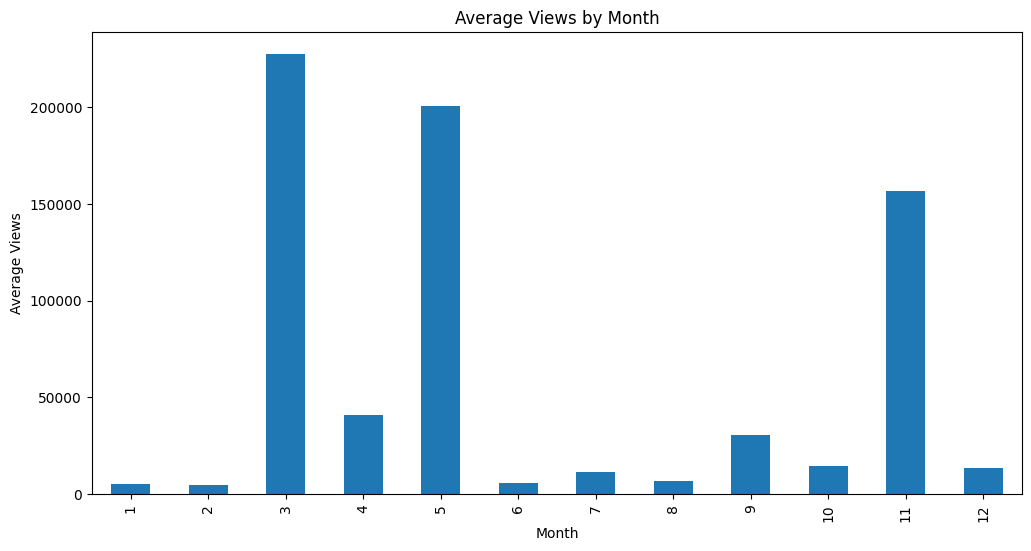

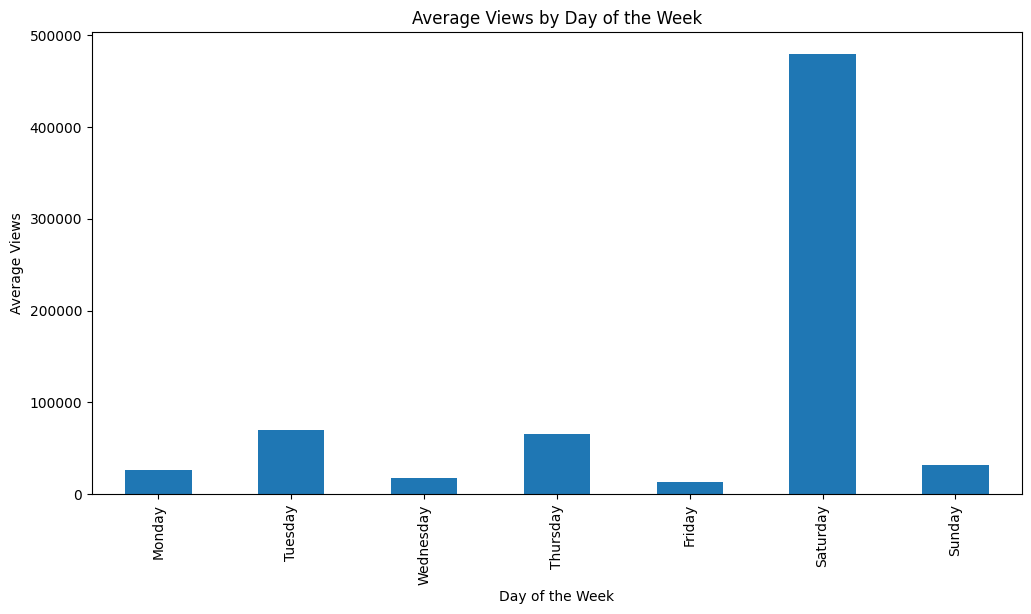

In [51]:
# Convert 'publishedAt' to datetime format
videos_df['publishedAt'] = pd.to_datetime(videos_df['publishedAt'])

# Time of Year Analysis
videos_df['month'] = videos_df['publishedAt'].dt.month
monthly_avg_views = videos_df.groupby('month')['viewCount'].mean()

plt.figure(figsize=(12, 6))
monthly_avg_views.plot(kind='bar')
plt.title('Average Views by Month')
plt.xlabel('Month')
plt.ylabel('Average Views')
plt.show()

# Day of the Week Analysis
videos_df['day_of_week'] = videos_df['publishedAt'].dt.day_name()
weekday_avg_views = videos_df.groupby('day_of_week')['viewCount'].mean()

plt.figure(figsize=(12, 6))
weekday_avg_views.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar')
plt.title('Average Views by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Views')
plt.show()


In [56]:
print(monthly_avg_views)
print(weekday_avg_views)

month
1       5305.600000
2       4667.470588
3     227454.650000
4      41007.793103
5     200669.090909
6       5755.466667
7      11335.375000
8       6618.166667
9      30479.625000
10     14567.857143
11    156560.416667
12     13494.230769
Name: viewCount, dtype: float64
day_of_week
Friday        13302.730769
Monday        26440.477273
Saturday     479134.555556
Sunday        31419.250000
Thursday      65058.043478
Tuesday       70119.730769
Wednesday     17502.777778
Name: viewCount, dtype: float64


#### Channel Growth Over Time

/tmp/ipykernel_753357/1804452372.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  channel_monthly_views = videos_df.groupby(['channelId', videos_df['publishedAt'].dt.to_period("M")])['viewCount'].sum().reset_index()


<Figure size 1200x600 with 0 Axes>

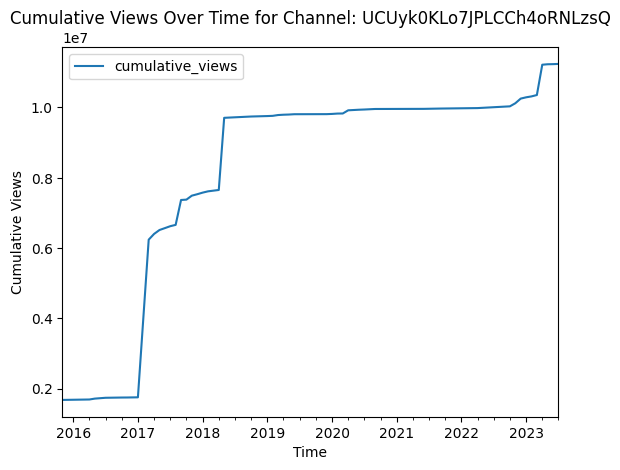

In [52]:
# Group by channelId and month
channel_monthly_views = videos_df.groupby(['channelId', videos_df['publishedAt'].dt.to_period("M")])['viewCount'].sum().reset_index()
channel_monthly_views['cumulative_views'] = channel_monthly_views.groupby('channelId')['viewCount'].cumsum()

# Plotting for a sample channel
sample_channel = channel_monthly_views['channelId'].iloc[0]
sample_data = channel_monthly_views[channel_monthly_views['channelId'] == sample_channel]

plt.figure(figsize=(12, 6))
sample_data.plot(x='publishedAt', y='cumulative_views')
plt.title(f'Cumulative Views Over Time for Channel: {sample_channel}')
plt.xlabel('Time')
plt.ylabel('Cumulative Views')
plt.show()


In [58]:
print(sample_data)

                   channelId publishedAt  viewCount  cumulative_views
0   UCUyk0KLo7JPLCCh4oRNLzsQ     2015-11    1677570           1677570
1   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-04      12140           1689710
2   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-05      25117           1714827
3   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-07      23713           1738540
4   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-08       2224           1740764
5   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-10       4725           1745489
6   UCUyk0KLo7JPLCCh4oRNLzsQ     2016-11       1095           1746584
7   UCUyk0KLo7JPLCCh4oRNLzsQ     2017-01       5090           1751674
8   UCUyk0KLo7JPLCCh4oRNLzsQ     2017-03    4484767           6236441
9   UCUyk0KLo7JPLCCh4oRNLzsQ     2017-04     162982           6399423
10  UCUyk0KLo7JPLCCh4oRNLzsQ     2017-05     111539           6510962
11  UCUyk0KLo7JPLCCh4oRNLzsQ     2017-06      53774           6564736
12  UCUyk0KLo7JPLCCh4oRNLzsQ     2017-07      54682           6619418
13  UCUyk0KLo7JPLCCh

## Competitive Analysis Veritasium - UCHnyfMqiRRG1u

Here's a roadmap for a competitive analysis on "Veritasium":
1. Content Analysis:

    Video Topics: Examine the topics of the most popular videos on Veritasium. Are there recurring themes or subjects?
    Video Length: What's the average duration of their videos? Do they lean more towards long-form or short-form content?
    Thumbnail Analysis: Thumbnails play a significant role in getting clicks. Are there common elements or styles in Veritasium's video thumbnails?

2. Engagement Metrics:

    Likes, Comments, and Shares: Measure the average engagement metrics of Veritasium's videos. High engagement often correlates with content quality and audience interest.
    Viewer Interaction: Look at the comment sections of their videos. How does Veritasium interact with its audience? Is there active engagement?

3. Publishing Schedule:

    Frequency: How often does Veritasium post new content?
    Timing: On which days and at what times do they typically publish new videos?

4. Channel Branding and Presentation:

    Channel Art and Description: How have they branded their YouTube channel's homepage?
    Playlists: Do they organize their videos into playlists? What are the themes of these playlists?

5. Collaborations and Partnerships:

    Has Veritasium collaborated with other YouTubers or brands? Collaborations can significantly increase reach and bring in new subscribers.

6. Monetization and Promotions:

    Do they have sponsored content? If so, who are their sponsors?
    Do they promote merchandise or other products?

7. Audience Demographics (if available):

    Understanding the target audience's age, gender, location, and other demographics can offer insights into content preferences.

To perform this analysis, you'd typically use a combination of manual review (visiting their channel and going through videos) and automated tools (like YouTube analytics tools, if you have access to them). Given I don't have direct access to current YouTube data here, you'd need to gather this data and then I can help interpret and provide insights based on the information you provide.

In [69]:
veritasium_videos = videos_df[videos_df['channelId'] == 'xxx']  # Replace with Veritasium's exact channelId


In [70]:
top_veritasium_videos = veritasium_videos.sort_values(by='viewCount', ascending=False).head(20)  # Top 20 videos for instance
print(top_veritasium_videos[['title', 'description']])


                                                   title  \
45815  Why Are 96,000,000 Black Balls on This Reservoir?   
45783             These are the asteroids to worry about   
45813                            World's Lightest Solid!   
45894                  Backspin Basketball Flies Off Dam   
45811                I Waterproofed Myself With Aerogel!   
45950                           World's Roundest Object!   
45765  The Simplest Math Problem No One Can Solve - C...   
45767          How a slinky falls in slow motion #shorts   
45926                                Anti-Gravity Wheel?   
45774        This Unstoppable Robot Could Save Your Life   
45928              Can Silence Actually Drive You Crazy?   
45812                       Can You Swim in Shade Balls?   
45730            Falling ladders - why does this happen?   
45749  The Man Who Accidentally Killed The Most Peopl...   
45773              How An Infinite Hotel Ran Out Of Room   
45772                            Math's 

In [73]:

veritasium_videos['duration_seconds'] = veritasium_videos['duration'].apply(iso8601_duration_to_seconds)
veritasium_videos['duration_minutes'] = veritasium_videos['duration_seconds'] / 60

average_duration = veritasium_videos['duration_minutes'].mean()
median_duration = veritasium_videos['duration_minutes'].median()
mode_duration = veritasium_videos['duration_minutes'].mode()[0]

print(f"Average Duration: {average_duration}")
print(f"Median Duration: {median_duration}")
print(f"Mode Duration: {mode_duration}")


Average Duration: 8.666572769953051
Median Duration: 6.6
Mode Duration: 1.0


/tmp/ipykernel_697033/1720830912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veritasium_videos['duration_seconds'] = veritasium_videos['duration'].apply(iso8601_duration_to_seconds)
/tmp/ipykernel_697033/1720830912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veritasium_videos['duration_minutes'] = veritasium_videos['duration_seconds'] / 60


In [74]:
all_tags = veritasium_videos['tags'].explode().value_counts()
print(all_tags.head(20))  # Top 20 tags


tags
['veritasium', 'science', 'physics']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     62
['bungy jump', 'acceleration', 'free fall', 'bridge bungy', 'bungee', 'bungee jump']                                                                                                                                                                                                                                                                                                                                                                   

In [76]:
# Filter videos that have a duration greater than 10 minutes
long_videos = veritasium_videos[veritasium_videos['duration_minutes'] > 10]

# Compute the average duration
average_duration_long = long_videos['duration_minutes'].mean()

print(f"Average Duration of videos longer than 10 minutes: {average_duration_long:.2f} minutes")


Average Duration of videos longer than 10 minutes: 17.44 minutes


### Title Analysis: Use text analytics or topic modeling on the title column to identify common themes or keywords in titles of popular videos.


One of the most used techniques for this is Latent Dirichlet Allocation (LDA).

Here's a step-by-step approach:

    Pre-processing:
        Tokenize the titles into words.
        Remove common stopwords.
        Apply stemming or lemmatization to reduce words to their base form.
    LDA Model Training:
        Use the processed titles to train an LDA model.
        Decide on the number of topics you want to extract (this can be tuned based on coherence scores or interpretability).
    Topic Visualization:
        Use the LDA model to assign topics to video titles.
        Visualize the topics using tools like pyLDAvis.
    Topic Analysis:
        Check which topics are most prevalent in videos from channels with the highest subscriber counts to identify themes that might be contributing to their popularity.

In [53]:

# Define a function to preprocess titles
def preprocess_title(title):
    # Convert to lowercase
    title = title.lower()
    
    # Remove punctuation
    title = title.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = title.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


In [60]:
# Apply preprocessing to the titles in the dataset
processed_titles = videos_df['title'].apply(preprocess_title).tolist()

# Create a dictionary representation of the documents
dictionary = Dictionary(processed_titles)

# Filter out words that occur in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Convert the processed titles to a bag-of-words representation
corpus = [dictionary.doc2bow(title) for title in processed_titles]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, passes=20, random_state=42)

# Get the topics
topics = lda_model.print_topics(num_words=20)
topics

[(0, '0.503*"klee" + 0.493*"irwin" + 0.004*"quantum"'),
 (1, '0.334*"klee" + 0.334*"irwin" + 0.332*"quantum"'),
 (2, '0.501*"klee" + 0.496*"irwin" + 0.003*"quantum"'),
 (3, '0.338*"quantum" + 0.331*"klee" + 0.331*"irwin"'),
 (4, '0.504*"klee" + 0.492*"irwin" + 0.003*"quantum"'),
 (5, '0.334*"klee" + 0.334*"irwin" + 0.332*"quantum"'),
 (6, '0.979*"quantum" + 0.011*"irwin" + 0.011*"klee"'),
 (7, '0.979*"quantum" + 0.010*"irwin" + 0.010*"klee"')]

/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
